In [28]:
import datetime, numpy as np, pandas as pd, yfinance as yf, pandas_ta as ta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
plt.style.use("seaborn-v0_8")      # nicer default charts
tf.random.set_seed(42)             # reproducibility

In [29]:
TICKER       = "AAPL"                 # change here for another equity
LOOKBACK     = 60                     # past days fed into LSTM
TRAIN_SPLIT  = 0.8                    # 80 % train / 20 % test
EPOCHS       = 50
BATCH_SIZE   = 32
START_DATE   = "2020-01-01"           # start of historical window
END_DATE     = datetime.date.today().isoformat()

In [30]:
raw = yf.download(TICKER, start=START_DATE, end=END_DATE, interval="1d")
if raw.empty:
    raise RuntimeError("No price data downloaded—check ticker or internet!")

import yfinance as yf

# Add auto_adjust=False to get both Close and Adj Close
data = yf.download('AAPL', start='2023-01-01', end='2024-01-01', auto_adjust=False)
print(data.columns)  # Now shows: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Your original code will work
adj_close = data['Adj Close']



df = raw[[price_col]].rename(columns={price_col: "Close"}).dropna()

# Optional technical indicators (drop if you only want price):
df["SMA_20"]  = ta.sma(df["Close"], length=20)
df["SMA_50"]  = ta.sma(df["Close"], length=50)
df["RSI_14"]  = ta.rsi(df["Close"], length=14)
# Keep only the Close column for modelling—indicators for insights only
df = df[["Close"]].dropna()

C:\Users\chauh\AppData\Local\Temp\ipykernel_3184\3083064420.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(TICKER, start=START_DATE, end=END_DATE, interval="1d")
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

MultiIndex([('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [31]:
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df[["Close"]])

def make_sequences(series, win):
    X, y = [], []
    for i in range(win, len(series)):
        X.append(series[i-win:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X, y = make_sequences(scaled_prices, LOOKBACK)
split = int(len(X) * TRAIN_SPLIT)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [32]:
model = models.Sequential([
    layers.Input(shape=(LOOKBACK, 1)),
    layers.LSTM(50, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(50, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(50),
    layers.Dropout(0.2),
    layers.Dense(25, activation="relu"),
    layers.Dense(1)
])
model.compile(optimizer="adam", loss="mse")

# Early stopping to avoid over-fit
es = callbacks.EarlyStopping(
        patience=5, restore_best_weights=True, monitor="val_loss")

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=1,
    callbacks=[es]
)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0617 - val_loss: 0.0118
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0062 - val_loss: 0.0032
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0030 - val_loss: 0.0059
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0020 - val_loss: 0.0049
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0020 - val_loss: 0.0057
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 505ms/step
Test RMSE: $9.09
Test MAE : $7.37


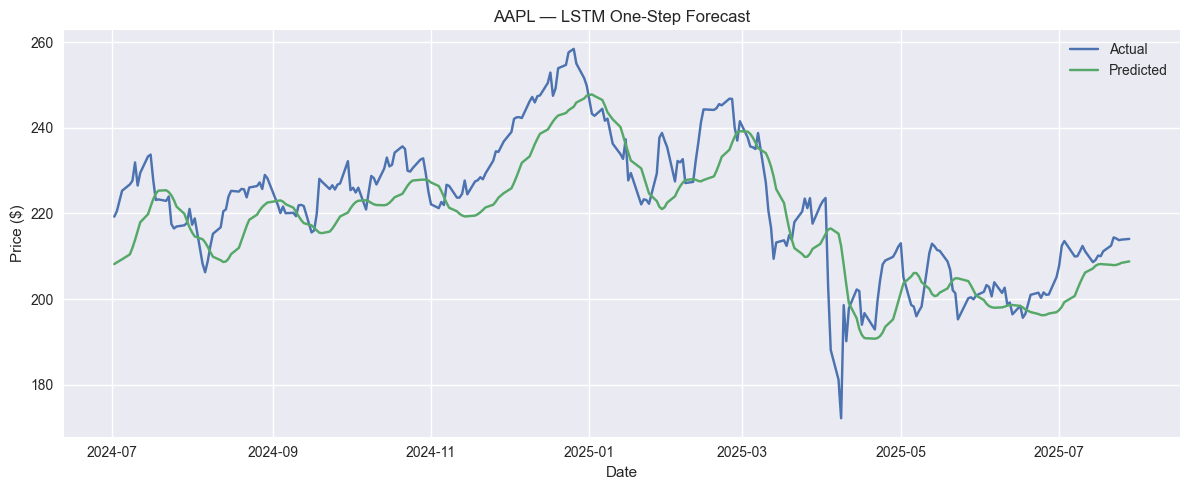

In [33]:
pred_scaled = model.predict(X_test)
pred_prices = scaler.inverse_transform(pred_scaled)
actual_prices = scaler.inverse_transform(y_test)

rmse = np.sqrt(np.mean((pred_prices - actual_prices) ** 2))
mae  = np.mean(np.abs(pred_prices - actual_prices))
print(f"Test RMSE: ${rmse:.2f}")
print(f"Test MAE : ${mae:.2f}")

# Plot prediction vs. actual
test_index = df.index[-len(pred_prices):]             # align with dates
plt.figure(figsize=(12, 5))
plt.plot(test_index, actual_prices, label="Actual")
plt.plot(test_index, pred_prices,  label="Predicted")
plt.title(f"{TICKER} — LSTM One-Step Forecast")
plt.xlabel("Date"); plt.ylabel("Price ($)")
plt.legend(); plt.tight_layout(); plt.show()

In [34]:
model.save('lstm_stock_prediction_model.keras') # Keras v3 native format
# Save scaler parameters
np.savez("scaler_params.npz", min_=scaler.data_min_, max_=scaler.data_max_)

In [35]:
def forecast_next(close_series: pd.Series) -> float:
    """Return next-day price forecast given latest Close series."""
    last_window = close_series.values[-LOOKBACK:].reshape(LOOKBACK, 1)
    last_scaled = scaler.transform(last_window)
    pred_scaled = model.predict(last_scaled.reshape(1, LOOKBACK, 1))[0][0]
    return float(scaler.inverse_transform([[pred_scaled]])[0][0])

next_price = forecast_next(df["Close"])
print(f"Tomorrow’s forecast for {TICKER}: ${next_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Tomorrow’s forecast for AAPL: $209.16
